## 9. 시계열을 위한 머신러닝

### 9.1.1

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [18]:
from cesium import datasets
eeg = datasets.fetch_andrzejak()

Loaded data from cached archive.


cesium github: https://github.com/cesium-ml/cesium/tree/main

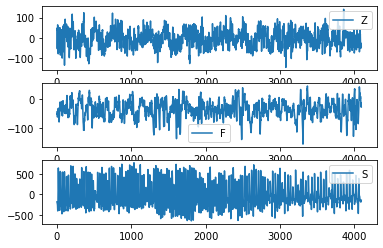

In [20]:
plt.subplot(3, 1, 1)
plt.plot(eeg["measurements"][0])
plt.legend(eeg['classes'][0])
plt.subplot(3, 1, 2)
plt.plot(eeg["measurements"][300])
plt.legend(eeg['classes'][300])
plt.subplot(3, 1, 3)
plt.plot(eeg['measurements'][450])
plt.legend(eeg['classes'][450])

- eeg 데이터셋 중 임의로 선택된 세 개의 표본에 대한 그래프
- 이들은 서로 독립적 & 서로 다른 시간에 서로 다른 환자를 대상으로 측정한 독립적인 시계열임
- Z와 F는 S보다 덜 편향 & y축의 각 범주는 꽤 다른 범위의 값으로 구성됨 => 진폭이 유용할 수 있다는 점 시사

### 특징 생성

In [21]:
import sys
sys.version

'3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]'

In [22]:
import cesium
print(cesium.__version__)

0.12.1


In [23]:
from cesium.featurize import featurize_time_series as ft

In [24]:
features_to_use = ['amplitude',
                  "percent_beyond_1_std",
                  "percent_close_to_median",
                  "skew",
                  "max_slope"]
fset_cesium = ft(times = eeg['times'],
                values = eeg['measurements'],
                errors = None,
                features_to_use = features_to_use,
                scheduler = None)

In [25]:
fset_cesium.head()

feature,amplitude,percent_beyond_1_std,percent_close_to_median,skew,max_slope
channel,0,0,0,0,0
0,143.5,0.327313,0.505004,0.032805,11107.796610
1,211.5,0.290212,0.640469,-0.092715,20653.559322
2,165.0,0.302660,0.515987,-0.004100,13537.627119
3,171.5,0.300952,0.541128,0.063678,17008.813559
4,170.0,0.305101,0.566268,0.142753,13016.949153


- 특징이 나타내려는 것 이해 & 이해한 바가 cesium의 계산과 일치한지 확인 필요

### 9.1.2

In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(fset_cesium.values, eeg['classes'], random_state=21)

In [27]:
# RandomForest
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators = 10,
                               max_depth = 3,
                               random_state = 21)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, n_estimators=10, random_state=21)

In [28]:
rf_clf.score(X_test, y_test)

0.616

In [29]:
# XGBoost
import xgboost as xgb
xgb_clf = xgb.XGBClassifier(n_estimators = 10,
                           max_depth = 3,
                           random_state = 21)
xgb_clf.fit(X_train, y_train)
xgb_clf.score(X_test, y_test)

[13:43:35] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\MJHwang\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\MJHwang\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.688

성능이 XGBoost가 더 좋을 뿐더러, RandomFores(배깅)가 XGBoost(부스팅)보다 약 50% 이상의 시간 더 사용함

In [35]:
# DTW 구현
def distDTW(ts1, ts2):
    DTW = {}
    for i in range(len(ts1)):
        DTW[(i, -1)] = np.inf
    for i in range(len(ts2)):
        DTW[(-1, i)] = np.inf
    DTW[(-1, -1)] = 0
    
    for i in range(len(ts1)):
        for j in range(len(ts2)):
            dist = (ts1[i] - ts2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],
                                     DTW[(i, j-1)],
                                     DTW[(i-1, j-1)])
    return sqrt(DTW[len(ts1)-1, len(ts2)-1])